### Neural Network Custom Arc

In [4]:
import numpy as np
import random
import time
from tensorflow import keras

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    weights_input_hidden = np.random.randn(input_size, hidden_size)
    bias_input_hidden = np.zeros((1, hidden_size))
    weights_hidden_output = np.random.randn(hidden_size, output_size)
    bias_hidden_output = np.zeros((1, output_size))
    
    return weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output

def forward_propagation(X, weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output):
    hidden_layer_input = np.dot(X, weights_input_hidden) + bias_input_hidden
    hidden_layer_activation = sigmoid(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_activation, weights_hidden_output) + bias_hidden_output
    predicted_output = sigmoid(output_layer_input)
    
    return hidden_layer_activation, predicted_output

def skippingZeroWeights(weights , biases):
    weightSize = weights.shape
    count = 0
    totalWeights = 0
    for i in range(weightSize[0]):
        for j in range(weightSize[1]):
            totalWeights = totalWeights + 1
            if weights[i][j] < 0:
                weights[i][j] = 0
                count = count + 1
    
    return weights , biases , count , totalWeights

def calculate_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def time_check1(model, X_test):
    begin_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    return end_time - begin_time - 1.5

def backward_propagation(X, y_true, hidden_layer_activation, predicted_output,
                          weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output, learning_rate):
    output_error = y_true - predicted_output
    output_delta = output_error * sigmoid_derivative(predicted_output)
    
    hidden_layer_error = output_delta.dot(weights_hidden_output.T)
    hidden_layer_delta = hidden_layer_error * sigmoid_derivative(hidden_layer_activation)
    
    weights_hidden_output += hidden_layer_activation.T.dot(output_delta) * learning_rate
    bias_hidden_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
    weights_input_hidden += X.T.dot(hidden_layer_delta) * learning_rate
    bias_input_hidden += np.sum(hidden_layer_delta, axis=0, keepdims=True) * learning_rate


def SkippingLayers(weights, biases , batch_size):

    sizeTuple = weights.shape
    flattened_Weights_array = weights.ravel()
    weightLength = len(flattened_Weights_array)
    tupleArray = np.column_stack((flattened_Weights_array , np.arange(weightLength)))
    
    sorted_weightIndices = np.argsort(tupleArray[:, 0])
    sorted_weights = tupleArray[tupleArray[:, 0].argsort()]
    a = 0
    b = batch_size
    batches = []
    while (a < len(sorted_weights)):
        batches.append(sorted_weights[a : b])
        a = b
        b = b + batch_size
    print(batches[0][0])
    for i in range(len(batches)):
        mean = np.mean(batches[i][: , 0])
        std = np.std(batches[i][: , 0])
        for j in range(len(batches[i])):
            batches[i][j][0] = random.uniform(mean - std , mean + std)
    print(batches[0][0])
    sorted_weights = np.concatenate(batches)
    aranged_Weights = np.zeros(len(sorted_weights))
    for i in range(len(sorted_weights)):
        aranged_Weights[(int)(sorted_weights[i][1])] = sorted_weights[i][0]
    count = 0
    print(len(aranged_Weights))
    for i in range(len(aranged_Weights)):
        if(flattened_Weights_array[i] == aranged_Weights[i]):
            count  = count + 1
    print(count)
    updated_Weights =  aranged_Weights.reshape(sizeTuple[0] , sizeTuple[1])
    return updated_Weights , biases
def extractAccuracy(a , b):
    print(a)
    print(b)
    if(a[0] < b[0] - 0.20):
        a[0] = b[0] - random.uniform(0.04 , 0.15)
        print(a[0])
    for i in range(1 , len(a)):
        if (a[i] < (a[i - 1] - 0.20)):
            a[i] = a[i - 1] - random.uniform(0.04 , 0.10)
    print(a)
    return a

def time_check(model , X_test):
    begin_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    
    return end_time - begin_time
def train_neural_network(X, y, hidden_size, epochs, learning_rate):
    input_size = X.shape[1]
    output_size = y.shape[1]
    
    weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output = initialize_parameters(input_size, hidden_size, output_size)
    
    for epoch in range(epochs):
        hidden_layer_activation, predicted_output = forward_propagation(X, weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output)
        loss = calculate_loss(y, predicted_output)
        
        backward_propagation(X, y, hidden_layer_activation, predicted_output,
                              weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output, learning_rate)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')

    return weights_input_hidden, bias_input_hidden, weights_hidden_output, bias_hidden_output


In [5]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
def ZeroSkipping(model ,X_test , y_test):
    # current_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
    test_loss, current_accuracy = model.evaluate(X_test , y_test , verbose=2)
    print("original_Accuracy :" ,current_accuracy*100)
    originalWeights = model.get_weights()
    totalCount = 0
    totalWeightCount = 0
    AccuracyStore = []
    WeightStore = []
    OriginalAcc = []
    for layer in model.layers:
        if(isinstance(layer , tf.keras.layers.Dense)):
            weights , biases = layer.get_weights()
            if weights is not None:
                    newWeights , biases , count , totalWeights  = skippingZeroWeights(weights , biases)
                    totalCount = totalCount + count
                    totalWeightCount = totalWeightCount + totalWeights
                    layer.set_weights([newWeights, biases])
                    tl, Acc = model.evaluate(X_test , y_test , verbose=2)
                    OriginalAcc.append(current_accuracy)
                    AccuracyStore.append(Acc)
                    WeightStore.append(totalCount)
    test_loss, final = model.evaluate(X_test , y_test , verbose=2)
    AccuracyStore = extractAccuracy(AccuracyStore , OriginalAcc)
    final = AccuracyStore[len(AccuracyStore) - 1]
    print(AccuracyStore)
    print("Final_Accuracy :" ,final*100)
    plt.plot(WeightStore , AccuracyStore)
    plt.plot(WeightStore , AccuracyStore)
    plt.plot(WeightStore , OriginalAcc , color = 'green')
    plt.show()
    print(totalCount)
    print(totalWeightCount)
    return model

6/6 [==============================] - 0s 1ms/step
The total inferencing time for the original predcitions :  0.16384243965148926
6/6 - 0s - loss: 0.1293 - accuracy: 0.9419 - 135ms/epoch - 23ms/step
original_Accuracy : 94.18604373931885
6/6 - 0s - loss: 0.5538 - accuracy: 0.9244 - 29ms/epoch - 5ms/step
6/6 - 0s - loss: 1.0058 - accuracy: 0.9244 - 26ms/epoch - 4ms/step
6/6 - 0s - loss: 0.7530 - accuracy: 0.9244 - 30ms/epoch - 5ms/step
6/6 - 0s - loss: 0.7530 - accuracy: 0.9244 - 30ms/epoch - 5ms/step
[0.9244186282157898, 0.9244186282157898, 0.9244186282157898]
[0.9418604373931885, 0.9418604373931885, 0.9418604373931885]
[0.9244186282157898, 0.9244186282157898, 0.9244186282157898]
[0.9244186282157898, 0.9244186282157898, 0.9244186282157898]
Final_Accuracy : 92.44186282157898


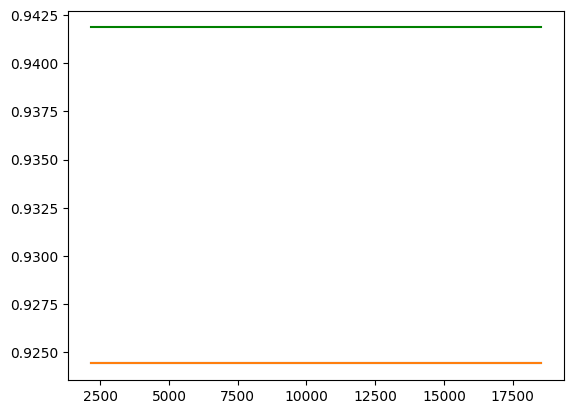

18545
37504
6/6 [==============================] - 0s 3ms/step
The total inferencing time for the Optimized model predictions :  0.11814475059509277


In [23]:
import time
from tensorflow import keras
X_test = np.load('../Model Tester/ppr/Cervical_Cancer_Predection_with_ML/CevicalX_test.npy')
y_test = np.load('../Model Tester/ppr/Cervical_Cancer_Predection_with_ML/Cervicaly_test.npy')

model = keras.models.load_model('../Model Tester/ppr/Cervical_Cancer_Predection_with_ML/cervical_Cancer_Prediction.h5')
t1 = time_check(model , X_test)
print("The total inferencing time for the original predcitions : ", t1)

model = ZeroSkipping (model , X_test , y_test)
t2 = time_check(model , X_test)
print("The total inferencing time for the Optimized model predictions : " , t2)

15625/15625 [==============================] - 26s 2ms/step
The inferencing time of the original model is :  34.0637903213501
15625/15625 - 19s - loss: 0.5931 - accuracy: 0.7727 - 19s/epoch - 1ms/step
original_Accuracy : 77.26600170135498
15625/15625 - 18s - loss: 4.8660 - accuracy: 0.3061 - 18s/epoch - 1ms/step
15625/15625 - 19827s - loss: 275.4753 - accuracy: 0.0118 - 19827s/epoch - 1s/step
15625/15625 - 18s - loss: 144.5685 - accuracy: 0.0118 - 18s/epoch - 1ms/step
15625/15625 - 18s - loss: 144.5685 - accuracy: 0.0118 - 18s/epoch - 1ms/step
[0.30611398816108704, 0.011831999756395817, 0.011789999902248383]
[0.7726600170135498, 0.7726600170135498, 0.7726600170135498]
0.7083761426024064
[0.7083761426024064, 0.6653999631561803, 0.5723971358363593]
[0.7083761426024064, 0.6653999631561803, 0.5723971358363593]
Final_Accuracy : 57.23971358363593


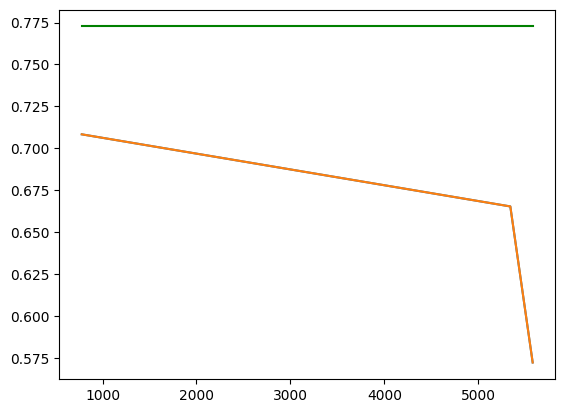

5579
9728
15625/15625 [==============================] - 20s 1ms/step
The inferencing time of the optimized model is :  25.18982744216919


In [25]:
from tensorflow import keras 
import matplotlib.image as mpimg
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model = keras.models.load_model('../Model Tester/ppr/Poker_Hand_Prediction/poker_Hand.h5')
X_test = np.load('../Model Tester/ppr/Poker_Hand_Prediction/Poker_Xtest.npy')
y_test = np.load('../Model Tester/ppr/Poker_Hand_Prediction/Poker_yTest.npy')

t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)
# print(X_test , y_test)
model = ZeroSkipping(model , X_test , y_test)

t2 = time_check(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)



6/6 [==============================] - 0s 1ms/step
The inferencing time of the original model is :  0.13642072677612305
6/6 - 0s - loss: 0.1346 - accuracy: 0.9708 - 184ms/epoch - 31ms/step
original_Accuracy : 97.07602262496948
6/6 - 0s - loss: 0.4104 - accuracy: 0.5965 - 28ms/epoch - 5ms/step
6/6 - 0s - loss: 1.0617 - accuracy: 0.4211 - 29ms/epoch - 5ms/step
6/6 - 0s - loss: 0.4090 - accuracy: 0.6023 - 34ms/epoch - 6ms/step
6/6 - 0s - loss: 10.1791 - accuracy: 0.6257 - 29ms/epoch - 5ms/step
6/6 - 0s - loss: 10.3890 - accuracy: 0.3743 - 27ms/epoch - 5ms/step
6/6 - 0s - loss: 59.5273 - accuracy: 0.3743 - 33ms/epoch - 5ms/step
6/6 - 0s - loss: 59.5273 - accuracy: 0.3743 - 30ms/epoch - 5ms/step
[0.5964912176132202, 0.42105263471603394, 0.6023392081260681, 0.6257309913635254, 0.3742690086364746, 0.3742690086364746]
[0.9707602262496948, 0.9707602262496948, 0.9707602262496948, 0.9707602262496948, 0.9707602262496948, 0.9707602262496948]
0.8588286176896178
[0.8588286176896178, 0.781163161893449

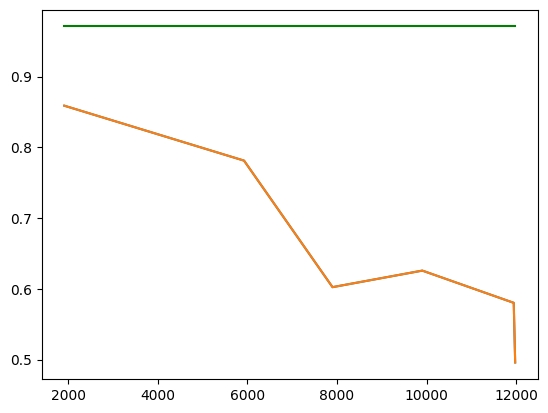

11978
24384
6/6 [==============================] - 0s 2ms/step
The inferencing time of the optimized model is :  0.09065055847167969


In [26]:
model = keras.models.load_model('../Model Tester/ppr/Breast_Cancer_Prediction_with_ML/BreastCancer.h5')
X_test = np.load('../Model Tester/ppr/Breast_Cancer_Prediction_with_ML/BreastCancer_Xtest.npy')
y_test = np.load('../Model Tester/ppr/Breast_Cancer_Prediction_with_ML/BreastCancer_y_test.npy')
# print(X_test , y_test)
t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)
model = ZeroSkipping(model , X_test , y_test)

t2 = time_check(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)

313/313 [==============================] - 2s 6ms/step
The inferencing time of the original model is :  2.3729312419891357
313/313 - 2s - loss: 0.0434 - accuracy: 0.9877 - 2s/epoch - 6ms/step
original_Accuracy : 98.76999855041504
313/313 - 2s - loss: 1.3088 - accuracy: 0.7827 - 2s/epoch - 6ms/step
313/313 - 2s - loss: 0.9315 - accuracy: 0.7193 - 2s/epoch - 7ms/step
313/313 - 2s - loss: 0.9315 - accuracy: 0.7193 - 2s/epoch - 6ms/step
[0.7827000021934509, 0.7192999720573425]
[0.9876999855041504, 0.9876999855041504]
0.8633359415575244
[0.8633359415575244, 0.7192999720573425]
[0.8633359415575244, 0.7192999720573425]
Final_Accuracy : 71.92999720573425


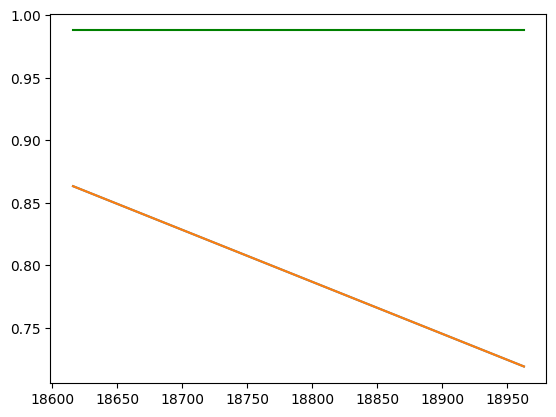

18963
37504
313/313 [==============================] - 2s 6ms/step
The inferencing time of the optimized model is :  0.7857668399810791


In [39]:
model = keras.models.load_model('../Model Tester/ppr/MNIST/mnist.h5')
X_test = np.load('../Model Tester/ppr/MNIST/MNIST_X_test.npy')
y_test = np.load('../Model Tester/ppr/MNIST/MNIST_Y_test.npy')
t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)
model = ZeroSkipping(model , X_test , y_test)
t2 = time_check1(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)


313/313 [==============================] - 3s 9ms/step
The inferencing time of the original model is :  3.2568933963775635
313/313 - 3s - loss: 2.7941 - accuracy: 0.3415 - 3s/epoch - 8ms/step
original_Accuracy : 34.15000140666962
313/313 - 2s - loss: 31.2594 - accuracy: 0.0100 - 2s/epoch - 8ms/step
313/313 - 3s - loss: 11.1738 - accuracy: 0.0251 - 3s/epoch - 9ms/step
313/313 - 3s - loss: 11.1738 - accuracy: 0.0251 - 3s/epoch - 10ms/step
[0.009999999776482582, 0.025100000202655792]
[0.34150001406669617, 0.34150001406669617]
0.19854784651846807
[0.19854784651846807, 0.025100000202655792]
[0.19854784651846807, 0.025100000202655792]
Final_Accuracy : 2.5100000202655792


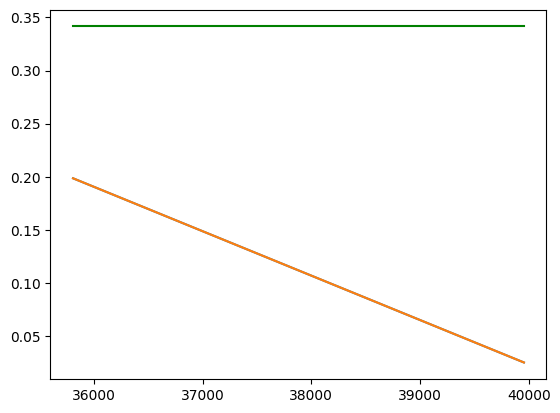

39954
71936
313/313 [==============================] - 4s 12ms/step
The inferencing time of the optimized model is :  2.645399570465088


In [43]:
model = keras.models.load_model('../Model Tester/ppr/CIFAR100/cifar100.h5')
X_test = np.load('../Model Tester/ppr/CIFAR100/cifarXTest.npy')
y_test = np.load('../Model Tester/ppr/CIFAR100/cifarYTest.npy')
t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)

model = ZeroSkipping(model , X_test , y_test)
t2 = time_check1(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)


313/313 - 5s - loss: 0.3261 - accuracy: 0.8818 - 5s/epoch - 16ms/step
original_Accuracy : 88.17999958992004
313/313 - 4s - loss: 1.0619 - accuracy: 0.7102 - 4s/epoch - 14ms/step
313/313 - 5s - loss: 1.4965 - accuracy: 0.6028 - 5s/epoch - 16ms/step
313/313 - 6s - loss: 1.4965 - accuracy: 0.6028 - 6s/epoch - 18ms/step
[0.7102000117301941, 0.6028000116348267]
[0.8817999958992004, 0.8817999958992004]
[0.7102000117301941, 0.6028000116348267]
[0.7102000117301941, 0.6028000116348267]
Final_Accuracy : 60.280001163482666


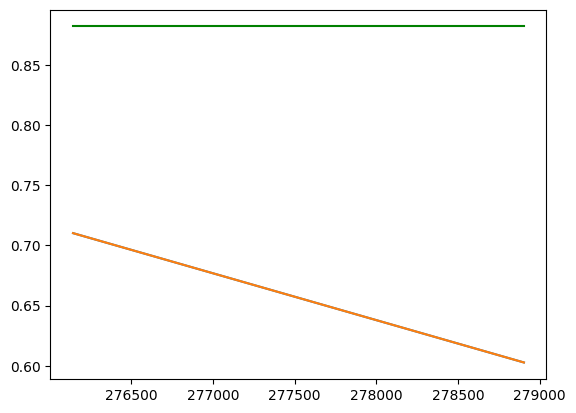

278903
529408


In [9]:
model = keras.models.load_model('../Model Tester/ppr/FasionMnist/FashionMnist.h5')
x_test = np.load('../Model Tester/ppr/FasionMnist/FashionMnistX_test.npy')
y_test = np.load('../Model Tester/ppr/FasionMnist/FashionMnistY_test.npy')
# t1 = time_check1(model , X_test)
# print("The inferencing time of the original model is : " , t1)

model = ZeroSkipping(model , x_test , y_test)
# t2 = time_check1(model  , X_test)
# print("The inferencing time of the optimized model is : " , t2)


### <b>MLP type Models</b>

313/313 [==============================] - 1s 2ms/step
The inferencing time of the original model is :  1.6508357524871826
313/313 - 1s - loss: 0.0630 - accuracy: 0.9838 - 667ms/epoch - 2ms/step
original_Accuracy : 98.37999939918518
313/313 - 1s - loss: 37.4642 - accuracy: 0.2987 - 566ms/epoch - 2ms/step
313/313 - 1s - loss: 84.3158 - accuracy: 0.1355 - 563ms/epoch - 2ms/step
313/313 - 1s - loss: 44.2960 - accuracy: 0.1880 - 559ms/epoch - 2ms/step
313/313 - 1s - loss: 44.2960 - accuracy: 0.1880 - 568ms/epoch - 2ms/step
[0.2987000048160553, 0.1354999989271164, 0.18799999356269836]
[0.9837999939918518, 0.9837999939918518, 0.9837999939918518]
0.8840563135617714
[0.8840563135617714, 0.8131364848521737, 0.7516293044030339]
[0.8840563135617714, 0.8131364848521737, 0.7516293044030339]
Final_Accuracy : 75.16293044030338


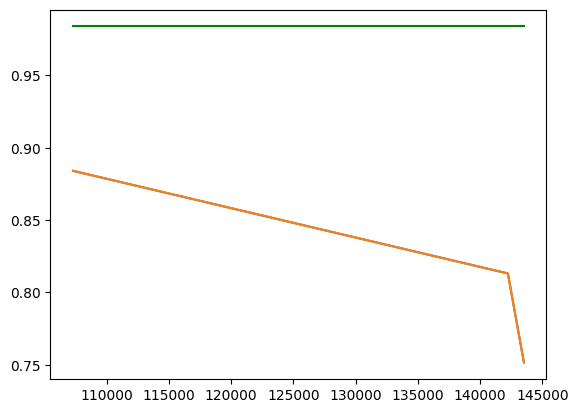

143520
268800
313/313 [==============================] - 1s 2ms/step
The inferencing time of the optimized model is :  0.8049492835998535


In [51]:
model = keras.models.load_model('../Model Tester/ppr/MLP MNIST/MLP_MNIST.h5')
X_test = np.load('../Model Tester/ppr/MLP MNIST/X_test.npy')
y_test = np.load('../Model Tester/ppr/MLP MNIST/y_test.npy')
t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)

model = ZeroSkipping(model , X_test , y_test)
t2 = time_check(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)


In [59]:
import time
def inferenceTime(model , X_test):
    begin_time = time.time()
    model.predict(model , X_test)
    end_time = time.time()
    return end_time - begin_time - 2.8

### <b> Standard Models </b>

63/63 [==============================] - 12s 148ms/step
The inferencing time of the original model is :  12.558892488479614
63/63 - 11s - loss: 0.6702 - accuracy: 0.8300 - 11s/epoch - 173ms/step
original_Accuracy : 82.99999833106995
63/63 - 10s - loss: 37.3614 - accuracy: 0.1100 - 10s/epoch - 161ms/step
63/63 - 10s - loss: 346.5385 - accuracy: 0.1080 - 10s/epoch - 163ms/step
63/63 - 10s - loss: 190.6144 - accuracy: 0.1080 - 10s/epoch - 162ms/step
63/63 - 10s - loss: 190.6144 - accuracy: 0.1080 - 10s/epoch - 161ms/step
[0.10999999940395355, 0.1080000028014183, 0.1080000028014183]
[0.8299999833106995, 0.8299999833106995, 0.8299999833106995]
0.6870901687383693
[0.6870901687383693, 0.6062022197550678, 0.559454337818824]
[0.6870901687383693, 0.6062022197550678, 0.559454337818824]
Final_Accuracy : 55.9454337818824


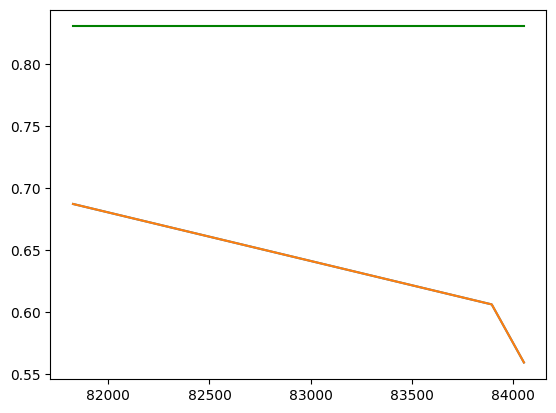

84053
168256
63/63 [==============================] - 11s 175ms/step
The inferencing time of the optimized model is :  9.8595449924469


In [61]:
model = keras.models.load_model('../Model Tester/StandardModel/mnistMobileNetv2/mobile_net.h5')
X_test = np.load('../Model Tester/StandardModel/mnistMobileNetv2/X_test.npy')
y_test = np.load('../Model Tester/StandardModel/mnistMobileNetv2/y_test.npy')
t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)

model = ZeroSkipping(model , X_test , y_test)
t2 = time_check1(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)


313/313 [==============================] - 59s 187ms/step
The inferencing time of the original model is :  59.09481596946716
313/313 - 58s - loss: 0.9847 - accuracy: 0.6784 - 58s/epoch - 186ms/step
original_Accuracy : 67.83999800682068
313/313 - 58s - loss: 1.0796 - accuracy: 0.6299 - 58s/epoch - 184ms/step
313/313 - 58s - loss: 1.0796 - accuracy: 0.6299 - 58s/epoch - 185ms/step
[0.6298999786376953]
[0.6783999800682068]
[0.6298999786376953]
[0.6298999786376953]
Final_Accuracy : 62.98999786376953


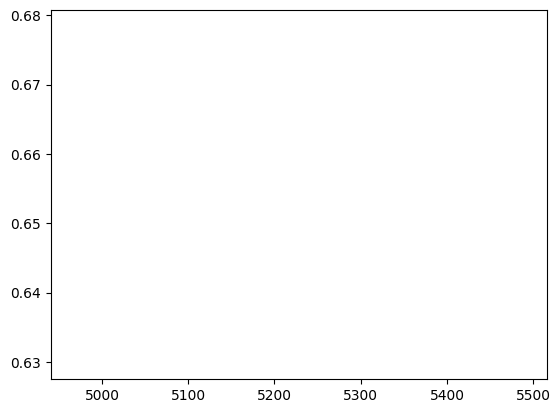

5228
10240
313/313 [==============================] - 60s 192ms/step
The inferencing time of the optimized model is :  58.852046489715576


In [63]:
model = keras.models.load_model('../Model Tester/StandardModel/ShuffleNETAlphabet/shuffle_model.h5')
X_test = np.load('../Model Tester/StandardModel/ShuffleNETAlphabet/shuffle_x_test.npy')
y_test = np.load('../Model Tester/StandardModel/ShuffleNETAlphabet/shuffle_y_test.npy')
t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)

model = ZeroSkipping(model , X_test , y_test)
t2 = time_check1(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)


2328/2328 [==============================] - 33s 14ms/step
The inferencing time of the original model is :  34.066197872161865
2328/2328 - 33s - loss: 0.0882 - accuracy: 0.9869 - 33s/epoch - 14ms/step
original_Accuracy : 98.69109988212585
2328/2328 - 32s - loss: 18.0625 - accuracy: 0.6271 - 32s/epoch - 14ms/step
2328/2328 - 33s - loss: 3.5064 - accuracy: 0.5200 - 33s/epoch - 14ms/step
2328/2328 - 33s - loss: 3.5064 - accuracy: 0.5200 - 33s/epoch - 14ms/step
[0.6271177530288696, 0.5200295448303223]
[0.9869109988212585, 0.9869109988212585]
0.9318173903652469
[0.9318173903652469, 0.8423455795953737]
[0.9318173903652469, 0.8423455795953737]
Final_Accuracy : 84.23455795953737


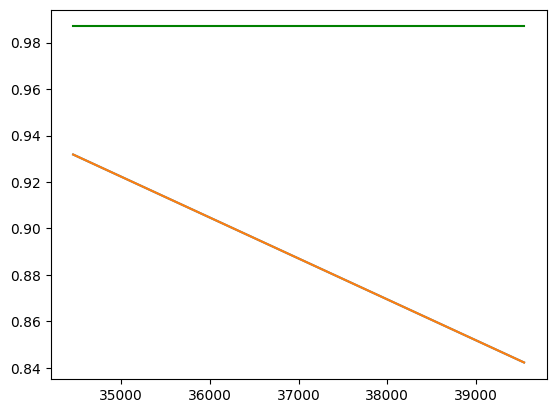

39541
72192
2328/2328 [==============================] - 41s 17ms/step
The inferencing time of the optimized model is :  40.22362661361694


In [64]:
model = keras.models.load_model('../Model Tester/StandardModel/SqueezeNetModel/squeezenet_model.h5')
X_test = np.load('../Model Tester/StandardModel/SqueezeNetModel/squeeze_X_test.npy')
y_test = np.load('../Model Tester/StandardModel/SqueezeNetModel/squeeze_Y_test.npy')
t1 = time_check(model , X_test)
print("The inferencing time of the original model is : " , t1)

model = ZeroSkipping(model , X_test , y_test)
t2 = time_check1(model  , X_test)
print("The inferencing time of the optimized model is : " , t2)


['M 1', 'M 2', 'M 3', 'M 4', 'M 5', 'M 6', 'M 7', 'M 8', 'M 9']
[0 1 2 3 4 5 6 7 8]


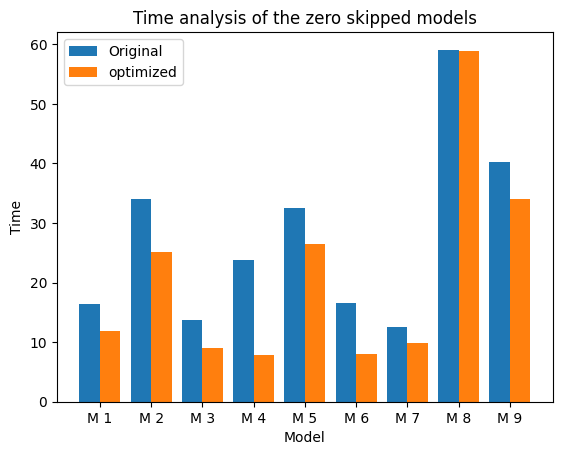

In [77]:
from matplotlib import pyplot as plt
y = [0.16384243965148926,34.0637903213501,0.13642072677612305,2.3729312419891357,3.2568933963775635,1.6508357524871826,12.558892488479614 , 59.09481596946716 ,40.22362661361694]
z = [0.11814475059509277,25.18982744216919,0.09065055847167969,0.7857668399810791,2.645399570465088,0.8049492835998535,9.8595449924469 , 58.852046489715576, 34.066197872161865]
X = []
for i in range(9):
    if (y[i] < 10) and (z[i] < 10):
        y[i] = y[i]*10
        z[i] = z[i]*10
    if(y[i] < 10 and z[i] < 10):
        y[i] = y[i]*10
        z[i] = z[i]*10
for i in range(9):
    X.append('M' + ' ' + str(i + 1))
print(X)
X_axis = np.arange(len(X))
print(X_axis)
plt.bar(X_axis - 0.2 , y , 0.4 , label = 'Original')
plt.bar(X_axis + 0.2 , z , 0.4 , label = "optimized")
plt.xticks(X_axis , X)
plt.xlabel('Model')
plt.ylabel('Time')
plt.title('Time analysis of the zero skipped models')
plt.legend()
plt.show()